# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import numpy as np
import torch
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, DownloadMode

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import (
    FPKey,
    QuantStyle,
    MiscPrompts,
    Contexts,
    Texts,
)

from PTQ.apply_ptq import applyPTQ
from PTQ.olmo_act_fns import patch_olmo_mlp
import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    chatbot_analysis
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""import torch._dynamo
torch._dynamo.config.suppress_errors = True"""

### Dataset for calibrating activations

In [ ]:
filepath = r'D:\ThesisData\wikitext'

destination_path = str(Path(filepath))
dataset = load_dataset(
    'wikitext', 'wikitext-103-raw-v1',
    split={
        'train': 'train[:30%]',
        'validation': 'validation[:10%]',
        'test': 'test[:10%]',
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
train_texts = dataset['train']

In [ ]:
calibration_texts = [t for t in dataset['train']["text"] if isinstance(t, str) and t.strip()]
#calibration_texts = [t for t in sub_txts["text"] if isinstance(t, str) and t.strip()]

In [ ]:
sub_txts = train_texts.take(100)

### Params

In [2]:
PARAMS:Dict = {
    'context': Contexts.C1.value,
    'prompt': MiscPrompts.Q11.value,
    'max_new_tokens': 250,
    'temperature': 0.8,
    'repetition_penalty': 1.1,
    'sample': True,
    'device': None
}

# Models and Tokenizer

In [3]:
def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True
    )

    return model

### allenai/OLMo

In [4]:
olmo1b_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO1B_TOKENIZER.value)

In [ ]:
olmo2t_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO7B2T_TOKENIZER.value)

In [ ]:
olmo7b_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO7B_TOKENIZER.value)

In [5]:
olmo1b_fp32 = load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32)

In [ ]:
olmo2t_fp32 = load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32)

In [ ]:
olmo7b_fp32 = load_test_model(FPKey.OLMO7B_FP.value, dtype=torch.float32)

In [ ]:
olmo1b_fp32

In [ ]:
olmo1b_fp32.config

In [6]:
olmo1b_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo1b_tokenizer,
    calibration_input=None,
    #calibration_input=sub_txts['text'],
    #calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=False,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

|| Quant Configs: 1.58bit | BitNet-style PTQ as: PTDQ ||
>> [STEP 1] Wrapping Linear layers (no weight quant yet)...
[SKIP] lm_head | Policy: Skip weight quantization!
>> [STEP 3]: Quantizing weights (after activation calibration)...
[INFO] Quantized ternary sparsity: 64.30%
[1.58-bit] model.layers.0.self_attn.q_proj | τ=0.0086 | α=0.0148 | shape=torch.Size([2048, 2048])
[INFO] Quantized ternary sparsity: 63.28%
[1.58-bit] model.layers.0.self_attn.k_proj | τ=0.0084 | α=0.0147 | shape=torch.Size([2048, 2048])
[INFO] Quantized ternary sparsity: 70.05%
[1.58-bit] model.layers.0.self_attn.v_proj | τ=0.0066 | α=0.0102 | shape=torch.Size([2048, 2048])
[INFO] Quantized ternary sparsity: 66.96%
[1.58-bit] model.layers.0.self_attn.o_proj | τ=0.0060 | α=0.0095 | shape=torch.Size([2048, 2048])
[INFO] Quantized ternary sparsity: 66.77%
[1.58-bit] model.layers.0.mlp.gate_proj | τ=0.0071 | α=0.0111 | shape=torch.Size([8192, 2048])
[INFO] Quantized ternary sparsity: 66.96%
[1.58-bit] model.layers.0.m

In [ ]:
olmo2t_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32),
    tokenizer=olmo2t_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=True,
    act_quant=True,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
olmo2t_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.OLMO7B_FP.value, dtype=torch.float32),
    tokenizer=olmo7b_tokenizer,
    calibration_input=None,
    #calibration_input=sub_txts['text'],
    #calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=False,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
olmo2t_bitnet_fp32

### NousResearch/DeepHermes

In [ ]:
dh3b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_3B.value)

In [ ]:
dh8b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_8B.value)

In [ ]:
dh3b_fp32 = load_test_model(FPKey.FP_3B.value, dtype=torch.float32)

In [ ]:
dh8b_fp32 = load_test_model(FPKey.FP_8B.value, dtype=torch.float32)

In [ ]:
dh3b_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.FP_3B.value, dtype=torch.float32),
    tokenizer=dh3b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=True,
    act_quant=True,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
dh3b_bitnet_fp32

In [ ]:
dh8b_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.FP_8B.value, dtype=torch.float32),
    tokenizer=dh8b_tokenizer,
    calibration_input=None,
    #calibration_input=sub_txts['text'],
    #calibration_input=PARAMS.get('prompt'),
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=False,
    act_bits=8,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
dh8b_bitnet_fp32

# Activation Lens and Logit Lens

In [ ]:
MiscPrompts.Q2.value

In [ ]:
dh8b_fp32.cpu()

In [ ]:
logit_lens.plot_logit_lens(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    #entropy=True,
)

In [ ]:
logit_lens.plot_logit_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo1b_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_ptdq_math.jpg',
    #kl=True,
)

In [ ]:
logit_lens.plot_logit_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo1b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_ptdq_math.jpg',
    #kl=True,
)

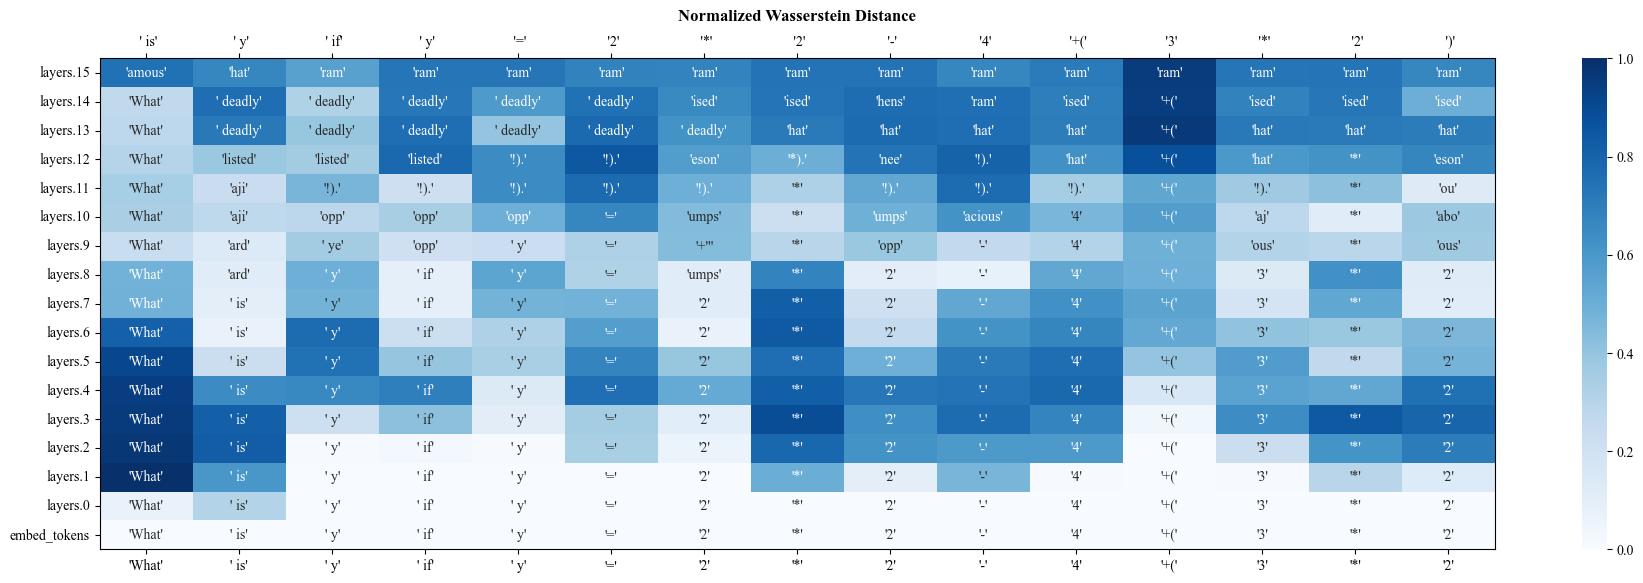

In [7]:
logit_lens.plot_comparing_lens(
    models=(olmo1b_fp32, olmo1b_bitnet_fp32),
    tokenizer=olmo1b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    #save_fig_path='Outputs/LogitLens/DH3B/nwd_3bfp32_ptdq_math.jpg',
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

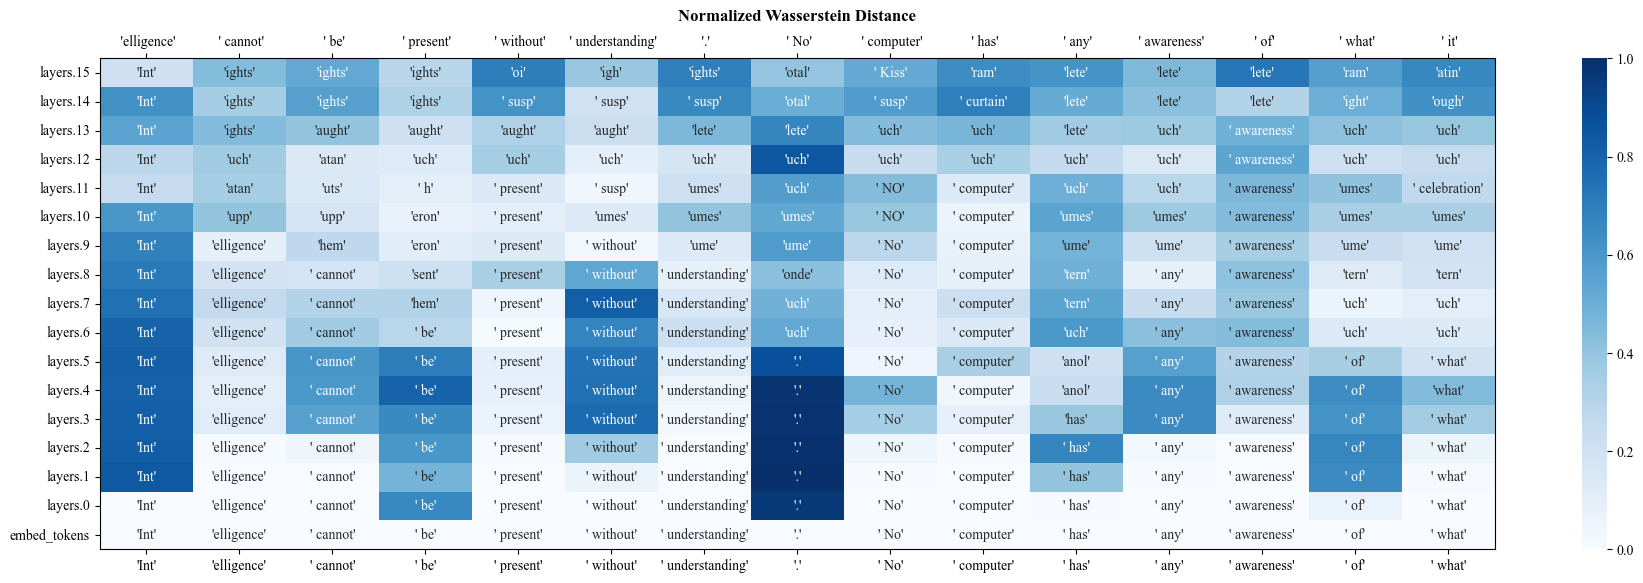

In [8]:
logit_lens.plot_comparing_lens(
    models=(olmo1b_fp32, olmo1b_bitnet_fp32),
    tokenizer=olmo1b_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    #save_fig_path='Outputs/LogitLens/DH3B/nwd_3bfp32_ptdq_math.jpg',
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

In [ ]:
logit_lens.plot_topk_lens(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    topk_n=5,
    save_fig_path='Outputs/LogitLens/DH3B/topk5logits_3bfp32_math.jpg'
    #save_fig_path=None,
    #top_down=False,
)

In [ ]:
logit_lens.plot_topk_lens(
    model=dh3b_bitnet_fp32,
    tokenizer=dh3b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    topk_n=5,
    save_fig_path='Outputs/LogitLens/DH3B/topk5logits_ptdq_math.jpg'
    #save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

In [ ]:
activation_lens.plot_activation_lens(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    metric='norm',
    save_fig_path='Outputs/LogitLens/DH3B/actnorm_3bfp32_math.jpg'
    #save_fig_path=None,
)

In [ ]:
activation_lens.plot_activation_lens(
    model=dh3b_bitnet_fp32,
    tokenizer=dh3b_tokenizer,
    input_ids=MiscPrompts.Q2.value,
    start_ix=0, end_ix=15,
    metric='norm',
    save_fig_path='Outputs/LogitLens/DH3B/actnorm_3b_ptdq_math.jpg'
    #save_fig_path=None,
)

# Dictionary Learning: SAE

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo1b_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=False,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=dh3b_bitnet_fp32,
    tokenizer=dh3b_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_tokens(
    model=dh3b_bitnet_fp32,
    tokenizer=dh3b_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=dh8b_fp32,
    tokenizer=dh8b_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)

In [11]:
dictionary_learning.plot_sae_heatmap(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo1b_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [10]:
dictionary_learning.plot_sae_heatmap(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo1b_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [9]:
dictionary_learning.plot_comparing_heatmap(
    models=(olmo1b_fp32, olmo1b_bitnet_fp32),
    tokenizer=olmo1b_tokenizer,
    inputs=Texts.T1.value,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    fig_path=None
)


Comparing SAE on layer 5


# Deep Hermes Chatbot Analysis (template only)

In [ ]:
dh_dict = {
    #'dh.3b-fp32': dh3b_fp32,
    #'dh.3b-bitnet.ptdq': dh3b_bitnet_fp32, # Check!
    #'dh.3b-bitnet.ptsq': dh3b_bitnet_fp32,
    #'dh.8b-fp32': dh8b_fp32,
    #'dh.8b-bitnet.ptdq': dh8b_bitnet_fp32,
    #'dh.8b-bitnet.ptsq': dh8b_bitnet_fp32,
}

In [ ]:
chatbot_analysis.run_chatbot_analysis(
    models=dh_dict,
    tokenizer=dh8b_tokenizer,
    full_path='logs/chatbot_logs'
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/chatbot_logs',
    parallel_plot=True
)